This notebook continues the [previous post](link://slug/fsx-experiments) by showing the actual code for distributed data processing.

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar
from dask_jobqueue import SLURMCluster
from distributed import Client, progress

In [2]:
import dask
import distributed
dask.__version__, distributed.__version__

('1.1.3', '1.26.0')

In [3]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


# Data exploration

Data are organized by year/month:

In [4]:
ls /fsx

2008/  2010/  2012/  2014/  2016/  2018/
2009/  2011/  2013/  2015/  2017/  QA/


In [5]:
ls /fsx/2008/

01/  02/  03/  04/  05/  06/  07/  08/  09/  10/  11/  12/


In [6]:
ls /fsx/2008/01/data  # one variable per file

air_pressure_at_mean_sea_level.nc*
air_temperature_at_2_metres_1hour_Maximum.nc*
air_temperature_at_2_metres_1hour_Minimum.nc*
air_temperature_at_2_metres.nc*
dew_point_temperature_at_2_metres.nc*
eastward_wind_at_100_metres.nc*
eastward_wind_at_10_metres.nc*
integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc*
lwe_thickness_of_surface_snow_amount.nc*
northward_wind_at_100_metres.nc*
northward_wind_at_10_metres.nc*
precipitation_amount_1hour_Accumulation.nc*
sea_surface_temperature.nc*
snow_density.nc*
surface_air_pressure.nc*


In [7]:
# hourly data over a month
dr = xr.open_dataarray('/fsx/2008/01/data/sea_surface_temperature.nc')
dr

<xarray.DataArray 'sea_surface_temperature' (time0: 744, lat: 640, lon: 1280)>
[609484800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.2812494 0.5624988 ... 359.43674 359.718
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time0    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2008-02-01T06:00:00
Attributes:
    standard_name:  sea_surface_temperature
    units:          K
    long_name:      Sea surface temperature
    nameECMWF:      Sea surface temperature
    nameCDM:        Sea_surface_temperature_surface

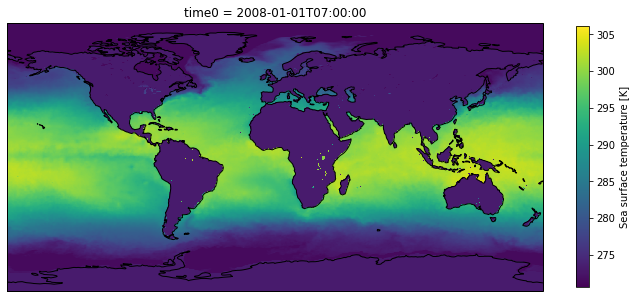

In [8]:
# Static plot of the first time slice
fig, ax = plt.subplots(1, 1, figsize=[12, 8], subplot_kw={'projection': ccrs.PlateCarree()})
dr[0].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
ax.coastlines();

What happens to the values over the land? Easier to check by an interactive plot.

In [9]:
import geoviews as gv
import hvplot.xarray

fig_hv = dr[0].hvplot.quadmesh(
    x='lon', y='lat', rasterize=True, cmap='viridis', geo=True,
    crs=ccrs.PlateCarree(), projection=ccrs.PlateCarree(), project=True,
    width=800, height=400, 
) * gv.feature.coastline

# fig_hv 

In [10]:
# This is just a hack to display figure on Nikola blog post
# If you know an easier way let me know
import holoviews as hv
from bokeh.resources import CDN, INLINE
from bokeh.embed import file_html
from IPython.display import HTML

HTML(file_html(hv.render(fig_hv), CDN))

So it turns out that the "temperature" over the land is set as 273.16K (0 degree celsius). A better way is probably masking them out.

# Serial read with master node

Let's see how slow it is to read one year of data with only master node.

In [11]:
# Just querying metadata will cause files being pulled from S3 to FSx.
# This takes a while at first executation. Much faster at second time.
%time ds_1yr = xr.open_mfdataset('/fsx/2008/*/data/sea_surface_temperature.nc', chunks={'time0': 50})
dr_1yr = ds_1yr['sea_surface_temperature']
dr_1yr

CPU times: user 64.4 ms, sys: 2.11 ms, total: 66.5 ms
Wall time: 78.6 ms


<xarray.DataArray 'sea_surface_temperature' (time0: 8784, lat: 640, lon: 1280)>
dask.array<shape=(8784, 640, 1280), dtype=float32, chunksize=(50, 640, 1280)>
Coordinates:
  * lon      (lon) float32 0.0 0.2812494 0.5624988 ... 359.43674 359.718
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time0    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2009-01-01T06:00:00
Attributes:
    standard_name:  sea_surface_temperature
    units:          K
    long_name:      Sea surface temperature
    nameECMWF:      Sea surface temperature
    nameCDM:        Sea_surface_temperature_surface

The aggregated size is ~29 GB:

In [12]:
dr_1yr.nbytes / 1e9  # GB

28.7834112

In [13]:
with ProgressBar():
    mean_1yr_ser = dr_1yr.mean().compute()

[########################################] | 100% Completed |  2min 13.0s


In [14]:
mean_1yr_ser

<xarray.DataArray 'sea_surface_temperature' ()>
array(282.24515, dtype=float32)

It takes ~2 min. Further reading the 10-year full data would take ~20 min. Such slowness encourages the use of a distributed cluster.

# Parallel read with dask cluster

## Cluster initialization

In [15]:
!sinfo  # spin-up 8 idle nodes with AWS ParallelCluster

PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
compute*     up   infinite      8   idle ip-172-31-0-255,ip-172-31-1-118,ip-172-31-3-103,ip-172-31-5-72,ip-172-31-11-149,ip-172-31-12-[112,127],ip-172-31-14-165


In [16]:
!mkdir -p ./dask_tempdir

In [17]:
# Reference: https://jobqueue.dask.org/en/latest/configuration.html
# - "cores" is the number of CPUs used per Slurm job. 
# Here fix it as 72, which is the number of vCPUs per c5n.18xl node. So one slurm job gets exactly one node.
# - "processes" specifies the number of dask workers in a single Slurm job.
# - "memory" specifies the memory requested in a single Slurm job.

cluster = SLURMCluster(cores=72, processes=36, memory='150GB', 
                       local_directory='./dask_tempdir')

In [18]:
# 8 node * 36 workers/node
cluster.scale(8*36)
cluster

Visit http://localhost:8787 for the dashboard.

In [19]:
# remember to also create dask client to talk to the cluster!
client = Client(cluster)  # automatically switches to distributed mode
client

<Client: scheduler='tcp://172.31.12.229:34319' processes=288 cores=576>

In [20]:
# now the default scheduler is dask.distributed
dask.config.get('scheduler')

'dask.distributed'

In [21]:
!sinfo  # nodes are now fully allocated

PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
compute*     up   infinite      8  alloc ip-172-31-0-255,ip-172-31-1-118,ip-172-31-3-103,ip-172-31-5-72,ip-172-31-11-149,ip-172-31-12-[112,127],ip-172-31-14-165


In [22]:
!squeue  # all are dask worker jobs, one per compute node

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
               184   compute dask-wor   centos  R       0:19      1 ip-172-31-0-255
               185   compute dask-wor   centos  R       0:19      1 ip-172-31-1-118
               186   compute dask-wor   centos  R       0:19      1 ip-172-31-3-103
               187   compute dask-wor   centos  R       0:19      1 ip-172-31-5-72
               188   compute dask-wor   centos  R       0:19      1 ip-172-31-11-149
               189   compute dask-wor   centos  R       0:19      1 ip-172-31-12-112
               190   compute dask-wor   centos  R       0:19      1 ip-172-31-12-127
               191   compute dask-wor   centos  R       0:19      1 ip-172-31-14-165


## Read 1-year data

In [23]:
# Actually, no need to reopen files. Can just reuse the previous dask graph and put it onto the cluster

ds_1yr = xr.open_mfdataset('/fsx/2008/*/data/sea_surface_temperature.nc', chunks={'time0': 25})
dr_1yr = ds_1yr['sea_surface_temperature']
dr_1yr

<xarray.DataArray 'sea_surface_temperature' (time0: 8784, lat: 640, lon: 1280)>
dask.array<shape=(8784, 640, 1280), dtype=float32, chunksize=(25, 640, 1280)>
Coordinates:
  * lon      (lon) float32 0.0 0.2812494 0.5624988 ... 359.43674 359.718
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time0    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2009-01-01T06:00:00
Attributes:
    standard_name:  sea_surface_temperature
    units:          K
    long_name:      Sea surface temperature
    nameECMWF:      Sea surface temperature
    nameCDM:        Sea_surface_temperature_surface

In [24]:
%time mean_1yr_par = dr_1yr.mean().compute()

CPU times: user 2.29 s, sys: 366 ms, total: 2.66 s
Wall time: 4.9 s


The throughput is like 29GB/5s ~ 6 GB/s. This seems to exceed our Lustre bandwidth of ~3GB/s. That's likely because the actual NetCDF files are compressed, and the 29 GB is just for in-memory arrays.

In [25]:
mean_1yr_par.equals(mean_1yr_ser) # consistent with serial result

False

In [26]:
len(dr_1yr.chunks[0])  # number of dask chunks

354

There are actually not that many chunks for dask workers, even though I am using quite small chunks. Let's try more files.

## Read multi-year data

For this part you might get "Too many files open" error. If so, run `sudo sh -c "ulimit -n 65535 && exec su $LOGNAME"` to raise the limit before starting Jupyter (ref: https://stackoverflow.com/a/17483998).

In [27]:
file_list = [f'/fsx/{year}/{month:02d}/data/sea_surface_temperature.nc' 
             for year in range(2008, 2018) for month in range(1, 13)]
len(file_list)  # number of files

120

In [28]:
file_list[0:3], file_list[-3:]  # span over multiple years

(['/fsx/2008/01/data/sea_surface_temperature.nc',
  '/fsx/2008/02/data/sea_surface_temperature.nc',
  '/fsx/2008/03/data/sea_surface_temperature.nc'],
 ['/fsx/2017/10/data/sea_surface_temperature.nc',
  '/fsx/2017/11/data/sea_surface_temperature.nc',
  '/fsx/2017/12/data/sea_surface_temperature.nc'])

In [29]:
# Will cause data being pulled from S3 to FSx.
# Will take a long time at first executation. Much faster at second time.
%time ds_10yr = xr.open_mfdataset(file_list, chunks={'time0': 50})
dr_10yr = ds_10yr['sea_surface_temperature']
dr_10yr

CPU times: user 594 ms, sys: 38.7 ms, total: 633 ms
Wall time: 721 ms


<xarray.DataArray 'sea_surface_temperature' (time0: 87672, lat: 640, lon: 1280)>
dask.array<shape=(87672, 640, 1280), dtype=float32, chunksize=(50, 640, 1280)>
Coordinates:
  * lon      (lon) float32 0.0 0.2812494 0.5624988 ... 359.43674 359.718
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time0    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2018-01-01T06:00:00
Attributes:
    standard_name:  sea_surface_temperature
    units:          K
    long_name:      Sea surface temperature
    nameECMWF:      Sea surface temperature
    nameCDM:        Sea_surface_temperature_surface

Near 300 GB!

In [31]:
dr_10yr.nbytes / 1e9 # GB

287.2836096

In [34]:
%time mean_10yr = dr_10yr.mean().compute()

CPU times: user 9.82 s, sys: 1.01 s, total: 10.8 s
Wall time: 15.2 s


Throughput is like 287GB/15s = 19 GB/s ?! Again that's likely due to HDF5/NetCDF compression.

Finally, instead of getting a scalar value (which is boring), let's get a time-series of global mean SST:

In [35]:
%time ts_10yr = dr_10yr.mean(dim=['lat', 'lon']).compute()

CPU times: user 11.7 s, sys: 1.41 s, total: 13.1 s
Wall time: 16 s


Despite my vastly inaccurate approximation (not masking out land, not weighting by grid cell areas, in order to keep the code simple), we can still see a clear increase of mean SST over the past years (0.2 °C is sort of a big deal for climate; more rigorous calculations [suggest more](https://www.epa.gov/climate-indicators/climate-change-indicators-sea-surface-temperature)).

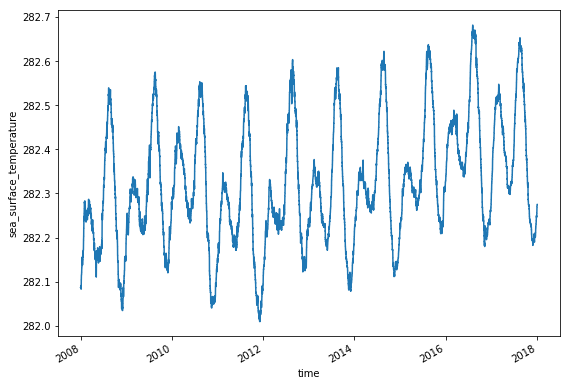

In [36]:
ts_10yr.plot(size=6)